In [2]:
import pandas as pd

# get the data and print the head
df = pd.read_excel("COVID_BRAZIL.xlsx")
df.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,FgMetro
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125,0,0,0,0,NaN,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125,1,1,0,0,NaN,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125,1,0,0,0,NaN,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125,1,0,0,0,NaN,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125,2,1,0,0,NaN,NaN,NaN


In [81]:
df

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125,0,0,0,0,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125,1,1,0,0,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125,1,0,0,0,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125,1,0,0,0,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125,2,1,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413051,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,DISTRITO FEDERAL,2020-06-14,25,3015268,22871,912,304,11,NaN,NaN
413052,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,DISTRITO FEDERAL,2020-06-15,25,3015268,23684,813,319,15,NaN,NaN
413053,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,DISTRITO FEDERAL,2020-06-16,25,3015268,25380,1696,348,29,NaN,NaN
413054,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,DISTRITO FEDERAL,2020-06-17,25,3015268,27140,1760,365,17,NaN,NaN


In [170]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# constants
TESTING_DAYS = 16 # how many days that will be used to verify the accuracy of the data

# metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_square_error(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def run_analysis(actual, predicted, state, test_type):
        # MAPE:
        mape = mean_absolute_percentage_error(actual, predicted)
        # MAD
        mad = mean_absolute_error(actual, predicted)
        # RMSE
        rmse = root_mean_square_error(actual, predicted)
        
        results = {"MAPE": mape, "MAD": mad, "RMSE": rmse, "State": state, "Test Type": test_type}
        results_series = pd.Series(results)
        
        return results_series
    
def clean_data(df, state, statistic):
        if state == "BRAZIL": # takes care of the case of analyzing Brazil rather than a single state
            df1 = df[df["estado"].isnull()] 
        else:
            df1 = df.query("(municipio != municipio) and (estado == '%s')" % state).reset_index()
            
        # removes bad data
        prev_row = 0
        for index, row in df1.iterrows():
            if (row[statistic] < prev_row): # accumulated cases cannot decrease
                df1 = df1.drop(index, axis = 0 )
            else:
                prev_row = row[statistic]
        return df1


In [176]:
from pmdarima import auto_arima

def run_test(df, state, statistic, axes):
    clean_df = clean_data(df, state, statistic)
    train, test = clean_df.loc[:(len(clean_df) - TESTING_DAYS), ["data", statistic]], clean_df.loc[len(clean_df) - TESTING_DAYS:, ["data",statistic]]
    
    train= train[train[statistic] != 0]
    arima_model = auto_arima(np.asarray(train[statistic]), trace=True, error_action='ignore', suppress_warnings=True)
    forecast = arima_model.predict(n_periods=len(test))
    forecast_df = pd.DataFrame({statistic: forecast, "data" : test["data"]})
    
    # generate plot
    
    #plt.figure(figsize=(16,8))
    ax = train.plot("data", statistic, label = "Training Data", ax = axes)
    test.plot("data", statistic, label = "Actual Data", ax = ax)
    forecast_df.plot("data", statistic, label = "ARIMA Prediction", ax = ax)
#     fig.plot(train["data"], train[statistic], label='Train')
#     fig.plot(test["data"], test[statistic], label='Actual Data')
#     fig.plot(test["data"], forecast, label='ARIMA Prediction')
#     fig.legend(loc='best')
    ax.title.set_text(state + " Graph " + statistic)
    #plt.savefig("ARIMA Results\plots\%s graph.png" % state)
    #plt.show()
    
    # create results
    results_df = pd.DataFrame()
    results_series = (run_analysis(test[statistic], forecast, state, "ARIMA " + statistic))
    results_series["order"] = (arima_model.get_params()["order"])
    results_df = results_df.append(results_series, ignore_index = True)
    return results_df

In [172]:
def run_full_test(df, state):
    fig, ax = plt.subplots(1, 2, figsize=(16,8))
    
    results_df = pd.DataFrame()
    results_df = results_df.append(run_test(df, state, "casosAcumulado", ax[0]))
    results_df = results_df.append(run_test(df, state, "obitosAcumulado", ax[1]))
    
    fig.suptitle("%s Graphs" % state, fontsize = 20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.show()
    fig.savefig("ARIMA Results\plots\%s graph.png" % state)
    
    return results_df

In [118]:
resultsCases, graphCases = run_test(df, "casosAcumulado", "BRAZIL")

# fig, (ax1, ax2) = plt.subplots(2)
# fig.suptitle('Vertically stacked subplots')
# ax1.plot(graphCases)
# ax2.plot(x, -y)


TypeError: run_test() missing 1 required positional argument: 'axes'

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1033.845, BIC=1048.501, Time=0.255 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1056.215, BIC=1061.100, Time=0.007 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1033.999, BIC=1041.327, Time=0.047 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1033.621, BIC=1040.949, Time=0.054 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1054.235, BIC=1056.678, Time=0.005 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1035.914, BIC=1045.685, Time=0.049 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1035.611, BIC=1045.381, Time=0.088 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1036.412, BIC=1048.625, Time=0.088 seconds
Total fit time: 0.596 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=395.014, BIC=408.838, Time=0.205 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=447.235,

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


,MAD,MAPE,RMSE,State,Test Type,order
0,422.489978,2.655658,469.051498,RO,ARIMA casosAcumulado,"(0, 2, 1)"
0,23.783682,5.475592,27.602862,RO,ARIMA obitosAcumulado,"(2, 2, 3)"


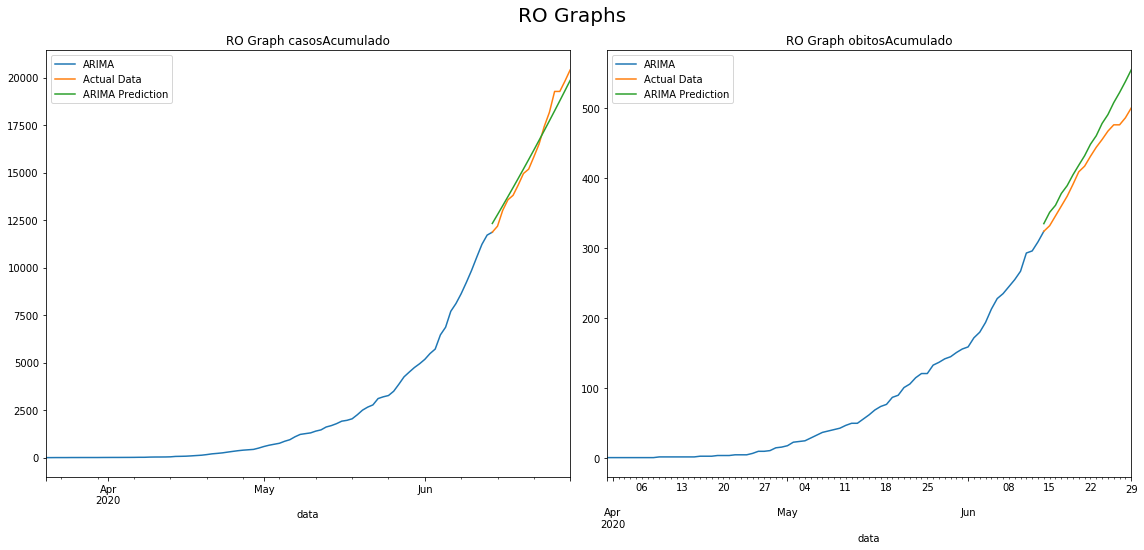

In [168]:
run_full_test(df, "RO")
#run_full_test(df, "BRAZIL")

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1033.845, BIC=1048.501, Time=0.319 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1056.215, BIC=1061.100, Time=0.009 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1033.999, BIC=1041.327, Time=0.042 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1033.621, BIC=1040.949, Time=0.090 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1054.235, BIC=1056.678, Time=0.008 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1035.914, BIC=1045.685, Time=0.102 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1035.611, BIC=1045.381, Time=0.144 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1036.412, BIC=1048.625, Time=0.180 seconds
Total fit time: 0.903 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=395.014, BIC=408.838, Time=0.267 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=447.235,

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=979.601, BIC=994.327, Time=0.285 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1000.102, BIC=1005.011, Time=0.015 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=975.335, BIC=982.698, Time=0.065 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=976.658, BIC=984.021, Time=0.095 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=998.122, BIC=1000.576, Time=0.010 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=976.102, BIC=985.919, Time=0.117 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=975.893, BIC=985.711, Time=0.110 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=977.893, BIC=990.165, Time=0.198 seconds
Total fit time: 0.905 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=318.235, BIC=331.463, Time=0.129 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=338.970, BIC=343.379,

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1323.597, BIC=1338.596, Time=0.335 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1334.959, BIC=1339.958, Time=0.014 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1336.340, BIC=1343.840, Time=0.022 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1336.003, BIC=1343.503, Time=0.046 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1332.975, BIC=1335.475, Time=0.010 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1331.770, BIC=1344.269, Time=0.222 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1318.969, BIC=1331.468, Time=0.269 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1322.420, BIC=1332.419, Time=0.217 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=1336.688, BIC

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=869.371, BIC=883.884, Time=0.253 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=874.087, BIC=878.925, Time=0.010 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=868.903, BIC=876.159, Time=0.056 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=869.336, BIC=876.592, Time=0.059 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=872.094, BIC=874.512, Time=0.009 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=870.901, BIC=880.576, Time=0.070 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=870.900, BIC=880.576, Time=0.077 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=869.757, BIC=881.851, Time=0.312 seconds
Near non-invertible roots for order (2, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Total fit time: 0.854 seconds
Performing stepwise search to minimize aic
Fit A

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1304.006, BIC=1318.732, Time=0.403 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1326.759, BIC=1331.667, Time=0.011 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1328.678, BIC=1336.042, Time=0.022 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1328.723, BIC=1336.086, Time=0.023 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1324.777, BIC=1327.232, Time=0.007 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1314.891, BIC=1327.162, Time=0.185 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1309.730, BIC=1322.002, Time=0.251 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1302.899, BIC=1320.079, Time=0.357 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=1305.550, BIC=1320.276, Time=0.280 seconds
Fit ARIMA(4,2,2)x(0,0,0,0) [intercept=True]; AIC=1307.164, BIC=1326.798, Time=0.358 seconds
Near non-invertible roots for order 

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1077.231, BIC=1091.887, Time=0.324 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1109.798, BIC=1114.683, Time=0.012 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1097.813, BIC=1105.140, Time=0.059 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1074.073, BIC=1081.401, Time=0.082 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1107.814, BIC=1110.257, Time=0.007 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1075.717, BIC=1085.487, Time=0.160 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1075.623, BIC=1085.394, Time=0.144 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1075.293, BIC=1087.506, Time=0.279 seconds
Total fit time: 1.075 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=336.704, BIC=350.195, Time=0.233 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=365.196,

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=899.307, BIC=914.034, Time=0.222 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=902.150, BIC=907.058, Time=0.009 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=903.594, BIC=910.957, Time=0.041 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=903.259, BIC=910.622, Time=0.044 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=900.159, BIC=902.614, Time=0.009 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=895.955, BIC=908.227, Time=0.167 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=895.218, BIC=905.036, Time=0.099 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=894.773, BIC=907.045, Time=0.137 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=896.138, BIC=910.864, Time=0.250 seconds
Fit ARIMA(0,2,4)x(0,0,0,0) [intercept=True]; AIC=884.627, BIC=899.353, Time=0.305 seconds
Fit ARIMA(1,2,4)x(0,0,0,0) [intercept=True]; AIC=897.591

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1217.095, BIC=1231.680, Time=0.296 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1225.843, BIC=1230.705, Time=0.009 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1220.083, BIC=1227.375, Time=0.056 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1218.205, BIC=1225.498, Time=0.078 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1223.939, BIC=1226.370, Time=0.008 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1217.913, BIC=1230.067, Time=0.239 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1217.871, BIC=1230.025, Time=0.258 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1211.471, BIC=1228.487, Time=0.426 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=1212.805, BIC=1227.390, Time=0.252 seconds
Fit ARIMA(4,2,2)x(0,0,0,0) [intercept=True]; AIC=1205.199, BIC=1224.646, Time=0.344 seconds
Fit ARIMA(4,2,1)x(0,0,0,0) [intercep

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=960.585, BIC=975.241, Time=0.263 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=981.937, BIC=986.823, Time=0.009 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=973.126, BIC=980.454, Time=0.040 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=956.542, BIC=963.869, Time=0.075 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=980.154, BIC=982.596, Time=0.010 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=956.606, BIC=966.376, Time=0.131 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=956.411, BIC=966.181, Time=0.149 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=959.588, BIC=971.801, Time=0.266 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=958.409, BIC=970.622, Time=0.

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1470.254, BIC=1485.118, Time=0.355 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1510.675, BIC=1515.630, Time=0.010 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1489.417, BIC=1496.849, Time=0.022 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1465.093, BIC=1472.525, Time=0.063 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1508.676, BIC=1511.153, Time=0.008 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1468.759, BIC=1481.146, Time=0.193 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1468.202, BIC=1480.589, Time=0.346 seco

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1270.834, BIC=1285.964, Time=0.263 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1343.643, BIC=1348.686, Time=0.011 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1320.469, BIC=1328.034, Time=0.028 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1277.152, BIC=1284.717, Time=0.104 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1341.656, BIC=1344.177, Time=0.007 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1276.923, BIC=1289.532, Time=0.235 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1272.833, BIC=1285.442, Time=0.263 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1273.130, BIC=1290.782, Time=0.362 seconds
Near non-invertible roots for order (3, 2, 2)(0, 0, 0, 0); set

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1176.317, BIC=1191.043, Time=0.362 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1171.131, BIC=1176.040, Time=0.008 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1172.878, BIC=1180.241, Time=0.020 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1172.611, BIC=1179.974, Time=0.062 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1169.210, BIC=1171.665, Time=0.011 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1160.331, BIC=1170.149, Time=0.193 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1154.301, BIC=1166.573, Time=0.195 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=1170.174, BIC=1179.991, Time=0.083 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=1152.159, BIC=1166.885, Time=0.245 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercept=True]; AIC=1169.132, BIC=1181.404, Time=0.099 seconds
Fit ARIMA(4,2,1)x(0,0,0,0) [intercep

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1314.329, BIC=1329.525, Time=0.321 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1338.495, BIC=1343.560, Time=0.009 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1329.294, BIC=1336.892, Time=0.020 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1312.946, BIC=1320.544, Time=0.070 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1336.532, BIC=1339.065, Time=0.007 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1311.487, BIC=1321.618, Time=0.165 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1313.060, BIC=1325.723, Time=0.242 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1314.404, BIC=1327.067, Time=0.281 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1311.295, BIC=1321.425, Time=0.184 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=1313.266, BIC=1325.929, Time=0.250 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercep

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1246.435, BIC=1261.883, Time=0.257 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1320.837, BIC=1325.987, Time=0.009 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1279.835, BIC=1287.560, Time=0.044 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1258.323, BIC=1266.047, Time=0.105 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1319.222, BIC=1321.797, Time=0.007 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1260.582, BIC=1273.456, Time=0.276 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1249.587, BIC=1262.461, Time=0.181 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1248.174, BIC=1266.197, Time=0.377 seconds
Near non-invertible roots for order (3, 2, 2)(0, 0, 0, 0); set

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1110.825, BIC=1125.824, Time=0.242 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1118.316, BIC=1123.315, Time=0.012 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1108.654, BIC=1116.154, Time=0.052 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1107.765, BIC=1115.264, Time=0.074 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1117.278, BIC=1119.778, Time=0.010 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1109.765, BIC=1119.764, Time=0.152 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1109.765, BIC=1119.764, Time=0.147 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1109.221, BIC=1121.721, Time=0.200 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Total fit time: 0.896 seconds
Performing stepwise search to mi

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1480.127, BIC=1495.698, Time=0.324 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1537.507, BIC=1542.698, Time=0.012 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1513.241, BIC=1521.026, Time=0.022 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1476.356, BIC=1484.141, Time=0.098 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1535.519, BIC=1538.115, Time=0.010 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1477.490, BIC=1487.870, Time=0.170 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1477.010, BIC=1487.391, Time=0.140 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1479.403, BIC=1492.379, Time=0.365 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 1.148 seconds
Performing stepwise search to mi

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1306.213, BIC=1321.661, Time=0.235 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1339.939, BIC=1345.088, Time=0.011 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1322.734, BIC=1330.458, Time=0.024 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1301.049, BIC=1308.773, Time=0.056 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1338.047, BIC=1340.622, Time=0.006 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1302.214, BIC=1312.513, Time=0.115 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1321.625, BIC=1331.924, Time=0.186 seconds
Near non-invertible roots for order (0, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1304.755, BIC=1317.629, Time=0.244 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); set

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1271.608, BIC=1287.179, Time=0.251 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1290.916, BIC=1296.106, Time=0.012 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1291.092, BIC=1298.877, Time=0.061 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1287.284, BIC=1295.069, Time=0.078 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1289.017, BIC=1291.612, Time=0.011 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1272.700, BIC=1285.676, Time=0.216 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1274.444, BIC=1287.420, Time=0.177 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1272.722, BIC=1290.888, Time=0.273 seconds
Near non-invertible roots for order (3, 2, 2)(0, 0, 0, 0); set

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1589.697, BIC=1605.328, Time=0.275 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1646.014, BIC=1651.224, Time=0.008 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1606.082, BIC=1613.898, Time=0.026 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1588.567, BIC=1596.382, Time=0.096 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1644.021, BIC=1646.626, Time=0.012 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1589.642, BIC=1600.063, Time=0.150 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1589.827, BIC=1600.247, Time=0.137 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1587.699, BIC=1600.725, Time=0.264 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=1590.360, BIC=1605.991, Time=0.360 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=1590.720, BIC=1603.746, Time=0.260 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercep

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1783.552, BIC=1799.644, Time=0.391 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1822.522, BIC=1827.886, Time=0.012 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1823.380, BIC=1831.427, Time=0.026 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1808.110, BIC=1816.157, Time=0.117 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1820.740, BIC=1823.422, Time=0.008 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1791.750, BIC=1805.161, Time=0.241 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1786.637, BIC=1800.047, Time=0.284 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1790.895, BIC=1809.670, Time=0.346 seconds
Near non-invertible roots for order (3, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,2,3)x(0,0,0,0) [intercept=True]; AIC=1795.520, BIC

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1049.098, BIC=1064.293, Time=0.283 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1080.065, BIC=1085.130, Time=0.013 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1060.457, BIC=1068.054, Time=0.045 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1045.510, BIC=1053.107, Time=0.052 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1078.277, BIC=1080.810, Time=0.008 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1047.256, BIC=1057.386, Time=0.096 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1047.274, BIC=1057.404, Time=0.147 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1048.086, BIC=1060.749, Time=0.203 seconds
Total fit time: 0.853 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=384.703, BIC=398.843, Time=0.336 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=433.557,

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1173.010, BIC=1188.141, Time=0.318 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1224.433, BIC=1229.476, Time=0.008 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1209.184, BIC=1216.749, Time=0.054 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1171.560, BIC=1179.126, Time=0.039 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1222.434, BIC=1224.956, Time=0.008 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1174.728, BIC=1187.337, Time=0.156 seconds
Near non-invertible roots for order (1, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1173.482, BIC=1186.091, Time=0.189 seco

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1300.097, BIC=1315.421, Time=0.287 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1352.941, BIC=1358.049, Time=0.013 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1323.984, BIC=1331.645, Time=0.028 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1294.805, BIC=1302.466, Time=0.093 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1350.941, BIC=1353.495, Time=0.007 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1296.660, BIC=1306.875, Time=0.119 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1296.663, BIC=1306.879, Time=0.163 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1298.131, BIC=1310.900, Time=0.204 seconds
Total fit time: 0.921 seconds
Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=403.685, BIC=417.977, Time=0.318 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=451.549,

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=807.872, BIC=822.804, Time=0.185 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=838.456, BIC=843.433, Time=0.013 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=806.538, BIC=814.004, Time=0.042 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=804.875, BIC=812.341, Time=0.060 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=837.078, BIC=839.567, Time=0.009 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=804.019, BIC=813.973, Time=0.091 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=806.006, BIC=818.449, Time=0.123 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=805.977, BIC=818.420, Time=0.194 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=804.348, BIC=814.303, Time=0.087 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=805.110, BIC=815.065, Time=0.067 seconds
Total fit time: 0.878 seconds
Performing stepwise search

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=897.522, BIC=912.178, Time=0.177 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=942.661, BIC=947.546, Time=0.007 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=933.805, BIC=941.133, Time=0.034 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=907.470, BIC=914.798, Time=0.050 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=941.023, BIC=943.466, Time=0.008 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=901.924, BIC=914.138, Time=0.176 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=901.733, BIC=913.946, Time=0.158 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=903.820, BIC=920.919, Time=0.319 seconds
Fit ARIMA(2,2,3)x(0,0,0,0) [intercept=True]; AIC=898.737, BIC=915.836, Time=0.249 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=909.464, BIC=919.235, Time=0.080 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=887.328

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1071.738, BIC=1086.868, Time=0.249 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1079.454, BIC=1084.498, Time=0.008 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1080.060, BIC=1087.626, Time=0.039 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1078.993, BIC=1086.559, Time=0.042 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1077.454, BIC=1079.976, Time=0.008 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1068.710, BIC=1081.319, Time=0.225 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=1068.309, BIC=1078.397, Time=0.084 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=1068.581, BIC=1081.190, Time=0.170 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=1068.023, BIC=1078.111, Time=0.174 seconds
Near non-invertible roots for order (1, 2, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the bord

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=1292.522, BIC=1308.032, Time=0.236 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=1342.144, BIC=1347.314, Time=0.008 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=1338.561, BIC=1346.316, Time=0.056 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=1311.408, BIC=1319.163, Time=0.071 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=1340.314, BIC=1342.899, Time=0.010 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=1305.062, BIC=1317.987, Time=0.303 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=1298.166, BIC=1311.091, Time=0.138 seconds
Fit ARIMA(3,2,2)x(0,0,0,0) [intercept=True]; AIC=1302.166, BIC=1320.261, Time=0.285 seconds
Near non-invertible roots for order (3, 2, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,2,3)x(0,0,0,0) [intercept=True]; AIC=1291.384, BIC

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=2058.025, BIC=2074.117, Time=0.347 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=2076.847, BIC=2082.211, Time=0.013 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=2078.815, BIC=2086.861, Time=0.020 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=2078.817, BIC=2086.864, Time=0.023 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=2075.079, BIC=2077.761, Time=0.006 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=2082.757, BIC=2096.167, Time=0.272 seconds
Fit ARIMA(2,2,1)x(0,0,0,0) [intercept=True]; AIC=2052.173, BIC=2065.584, Time=0.153 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=2064.538, BIC=2075.266, Time=0.103 seconds
Fit ARIMA(2,2,0)x(0,0,0,0) [intercept=True]; AIC=2071.196, BIC=2081.925, Time=0.027 seconds
Fit ARIMA(3,2,1)x(0,0,0,0) [intercept=True]; AIC=2051.653, BIC=2067.746, Time=0.073 seconds
Fit ARIMA(3,2,0)x(0,0,0,0) [intercep

C:\Users\piphi\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


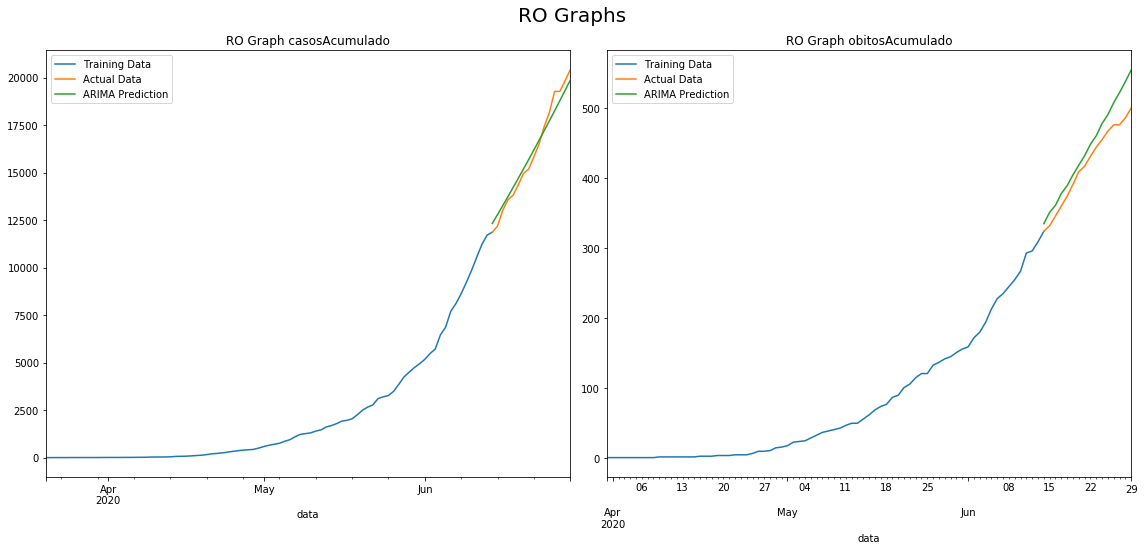

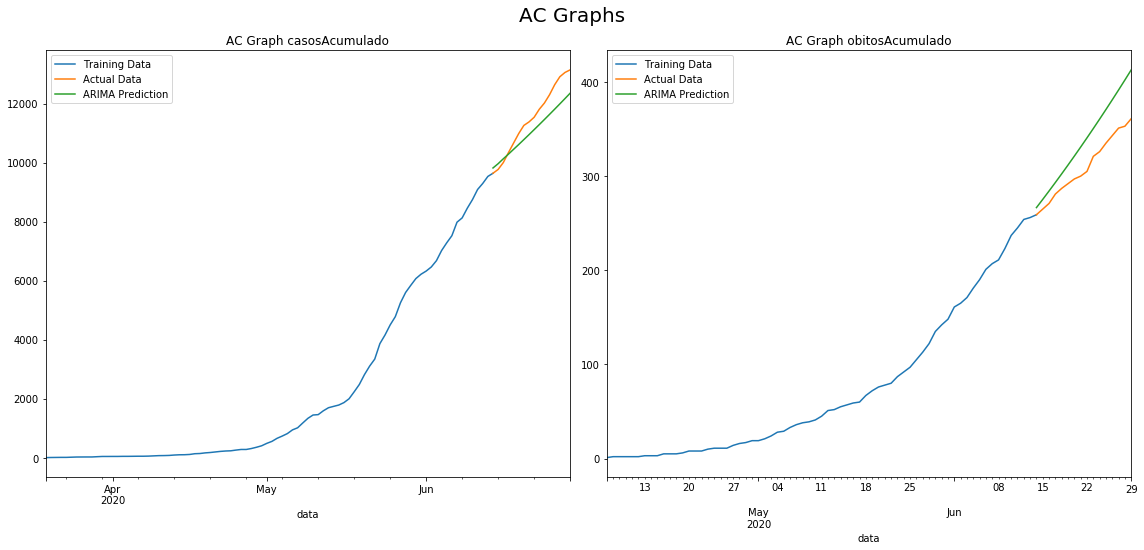

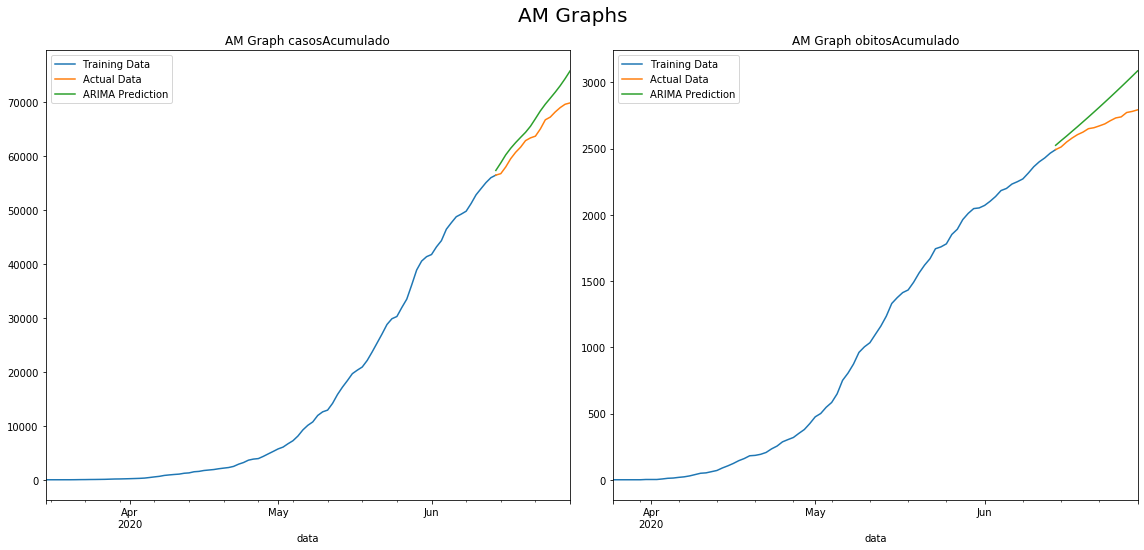

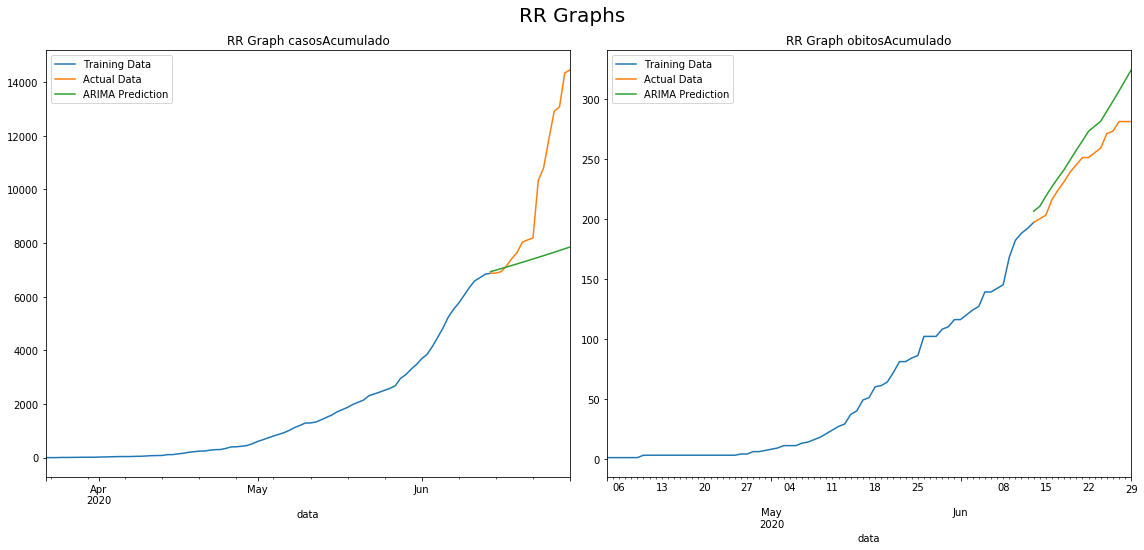

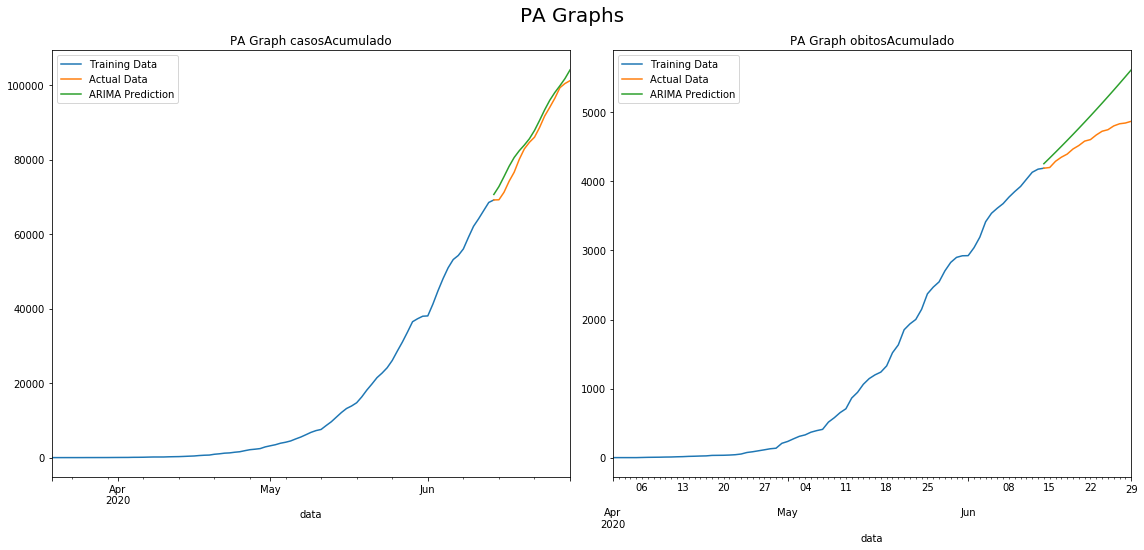

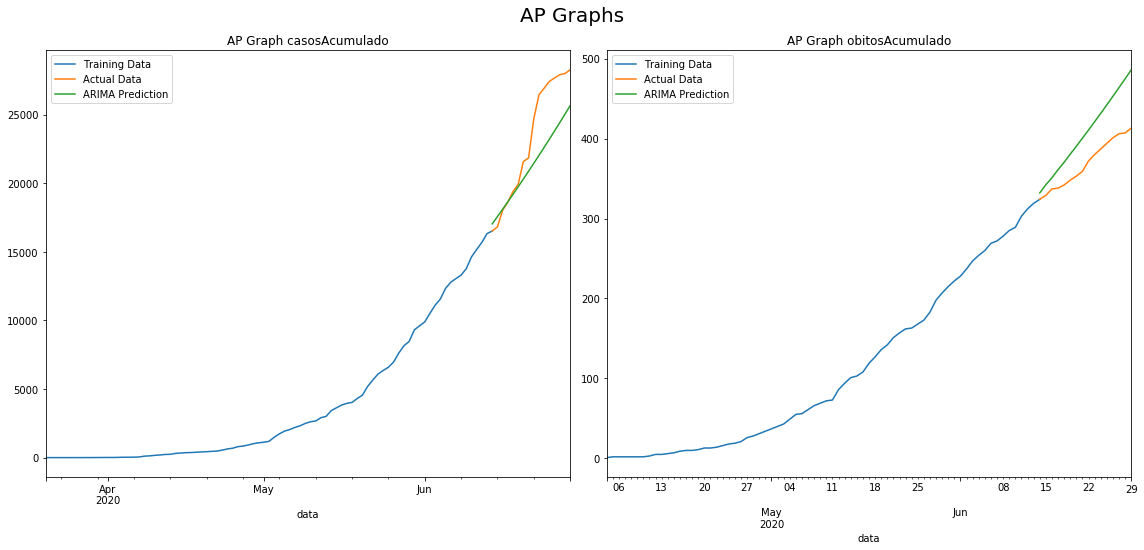

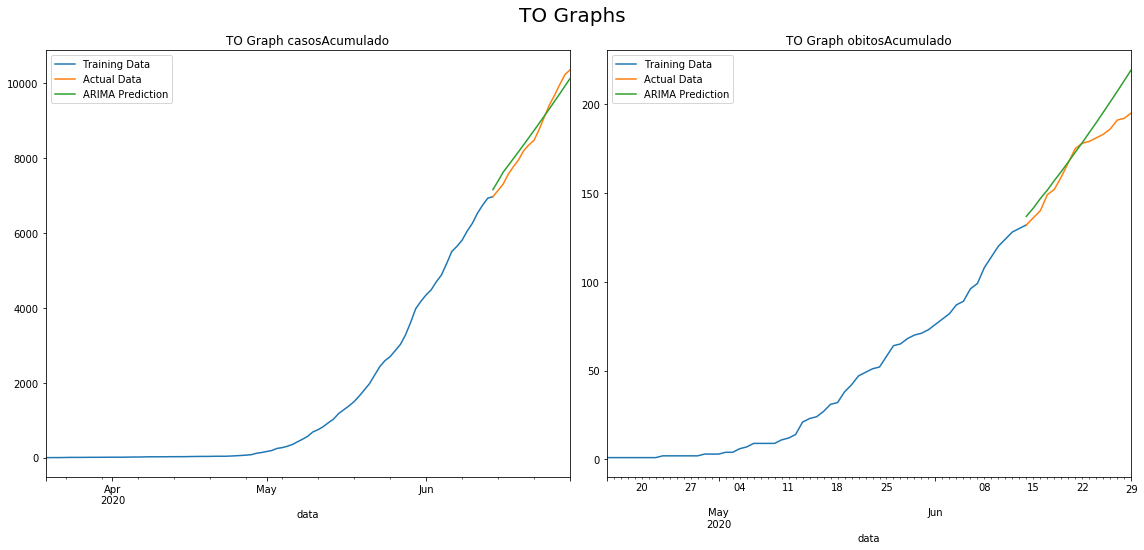

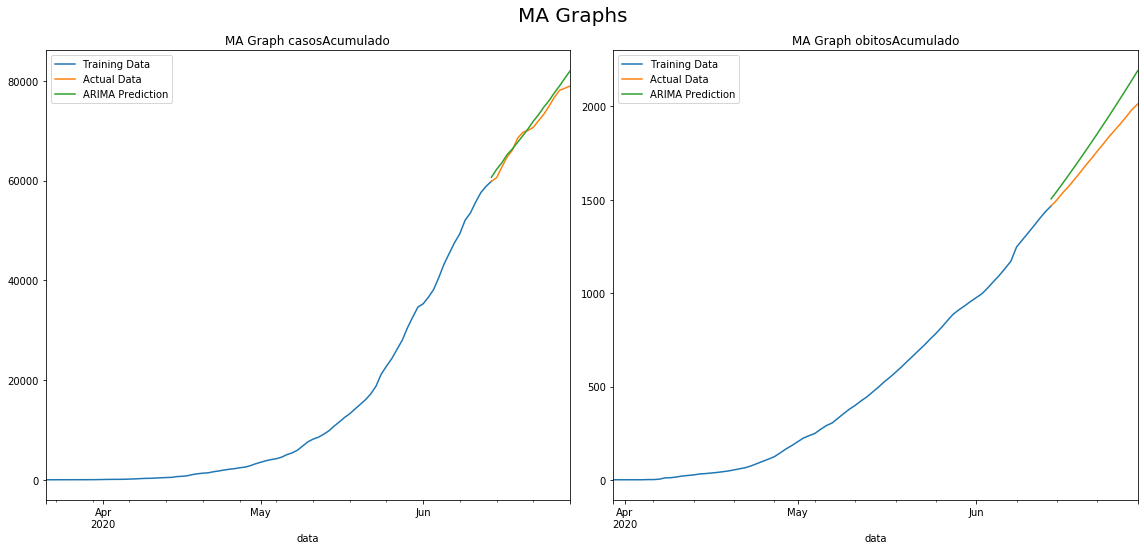

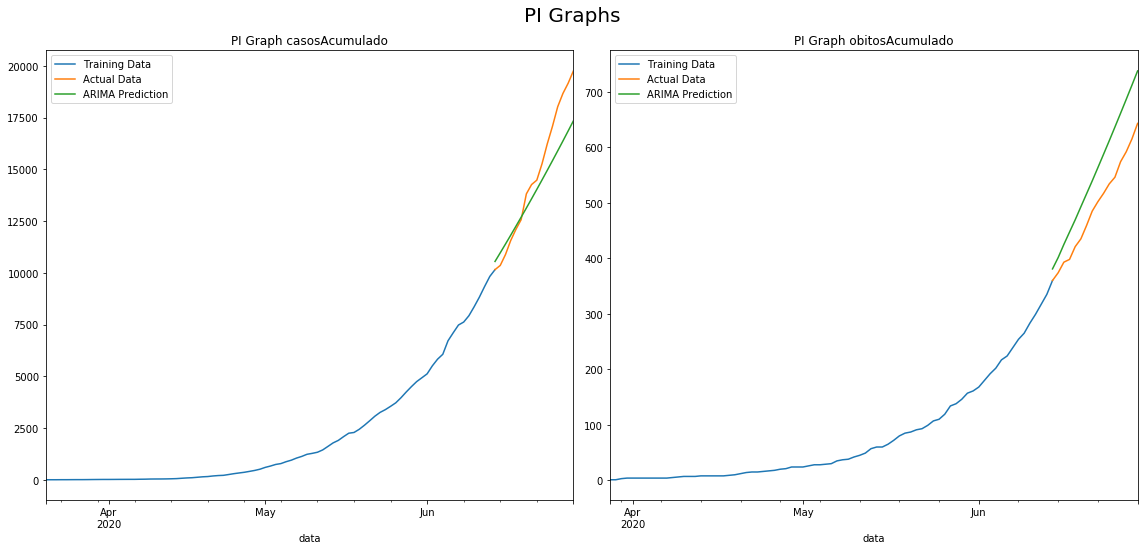

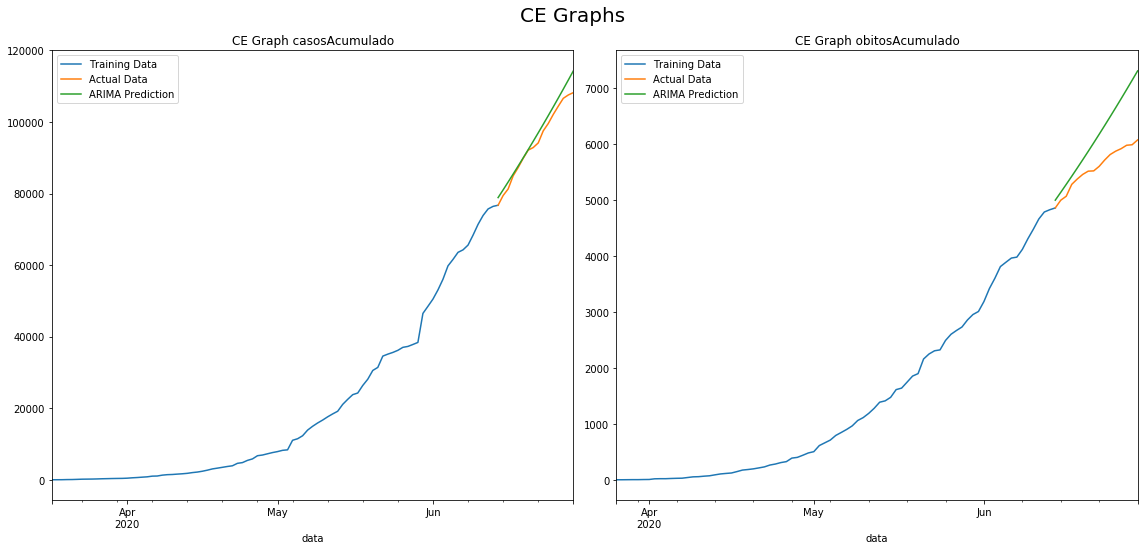

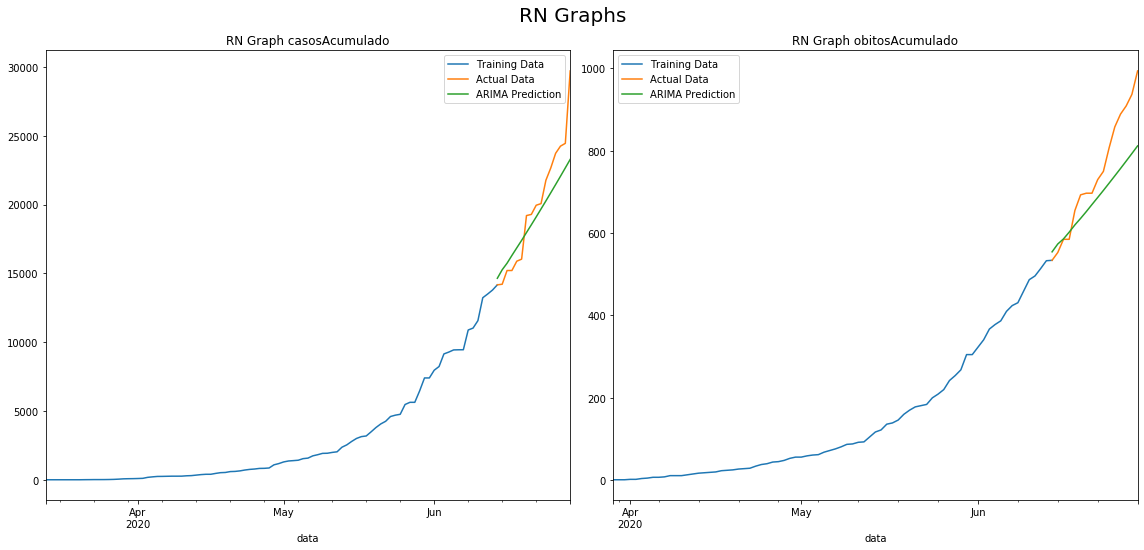

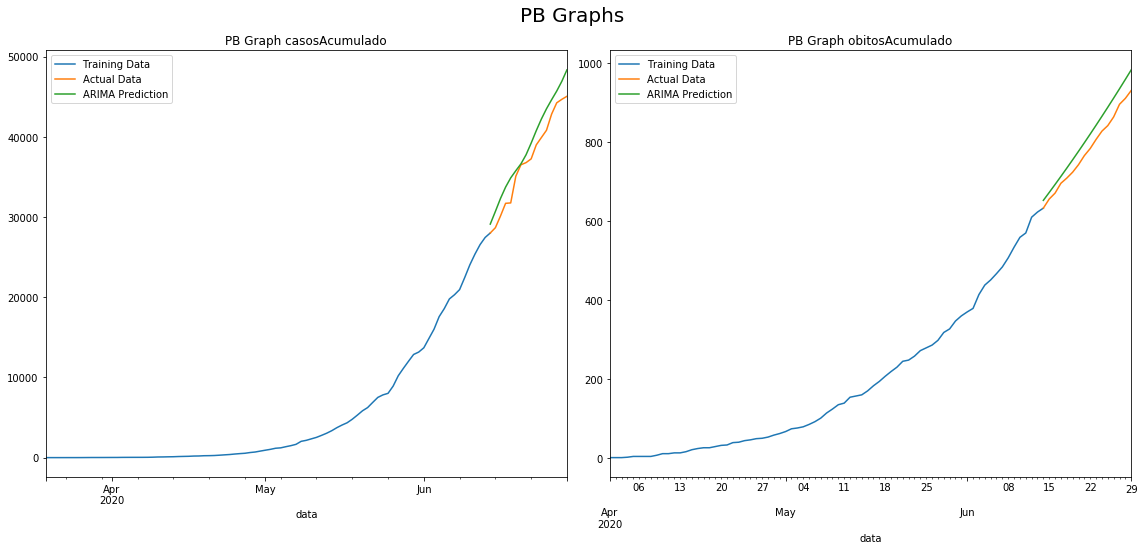

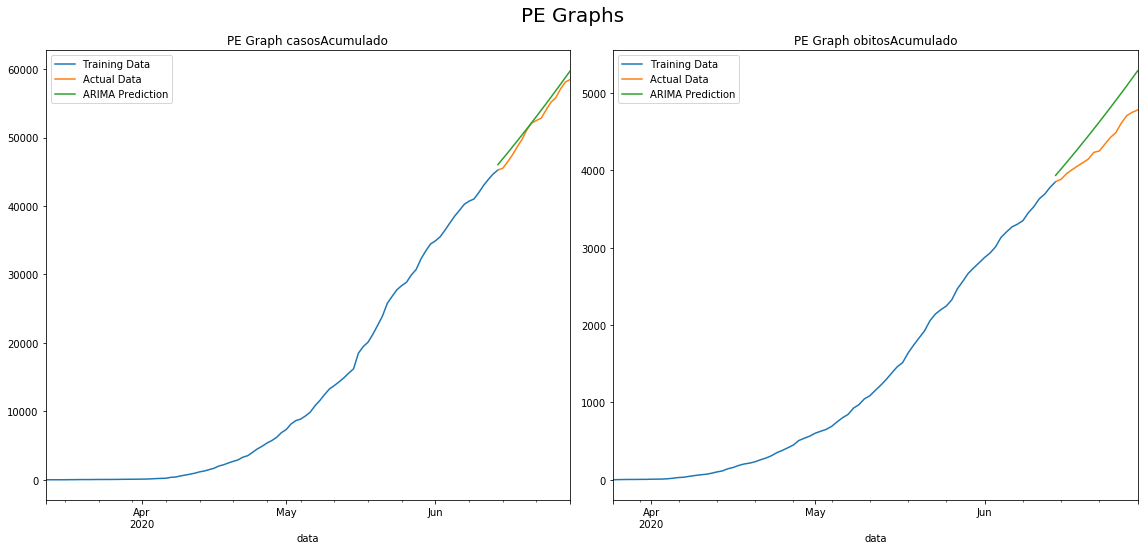

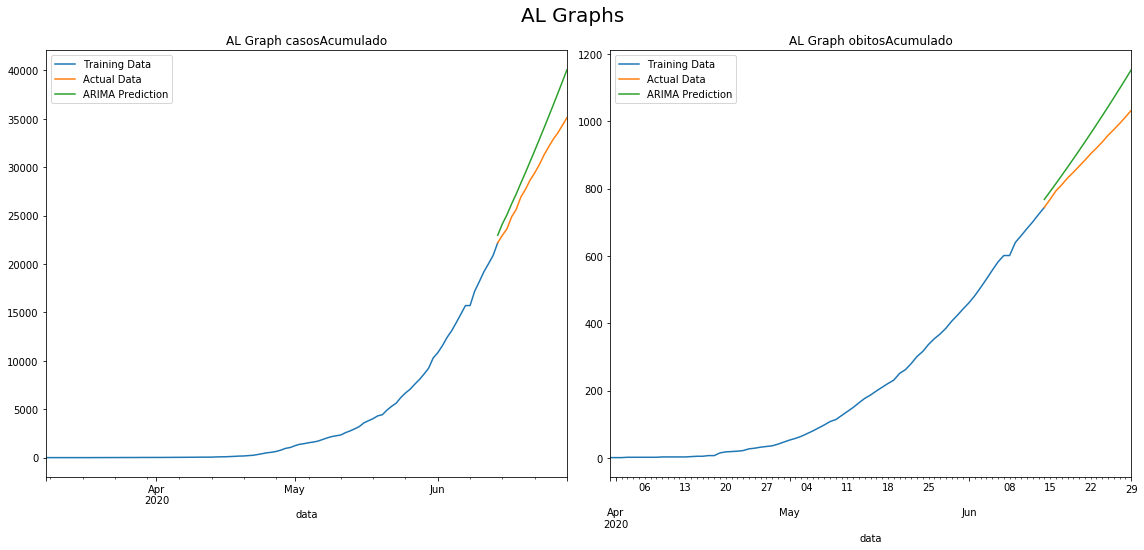

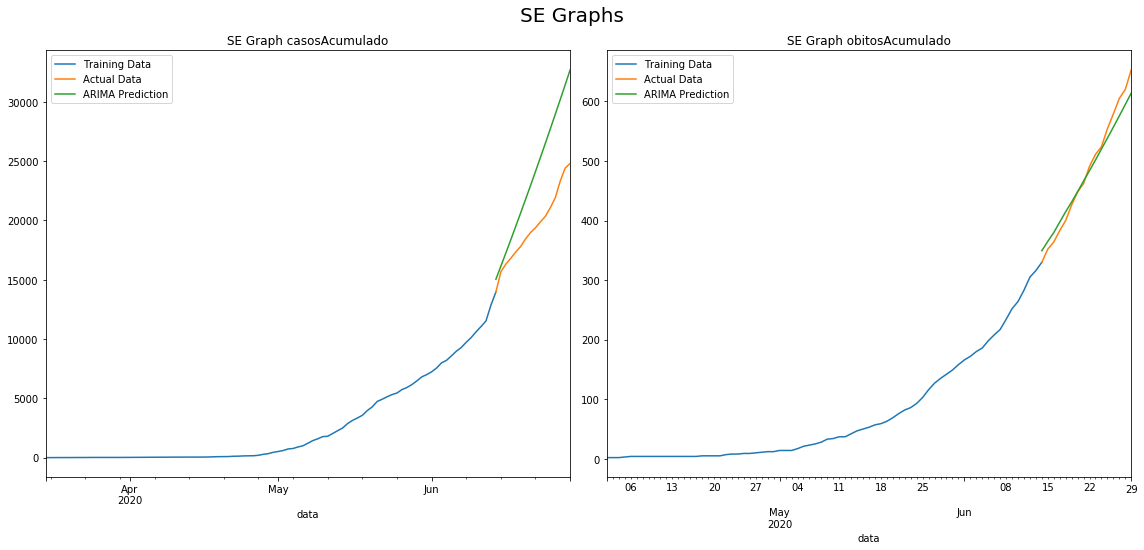

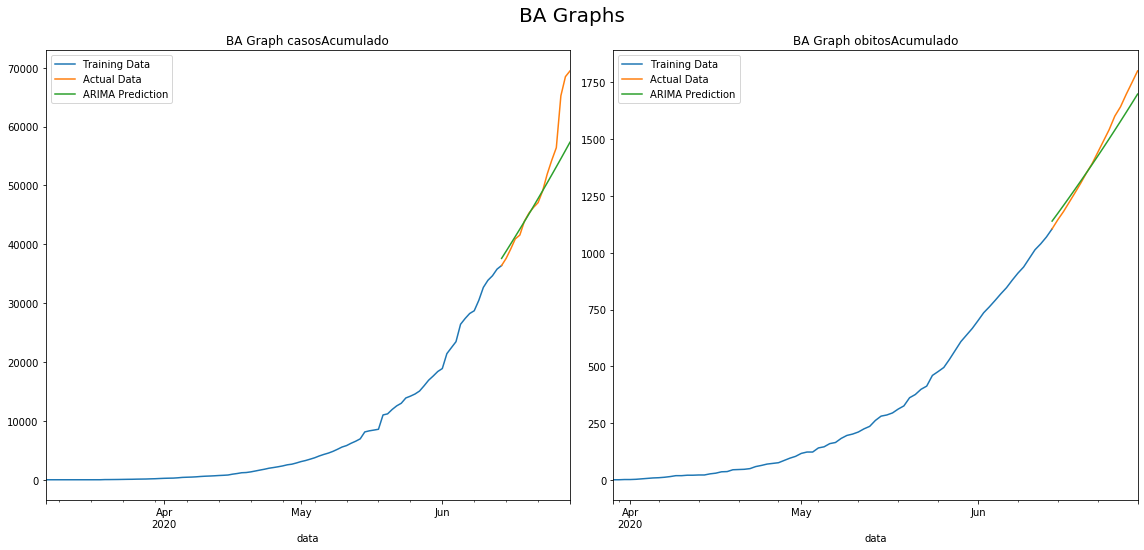

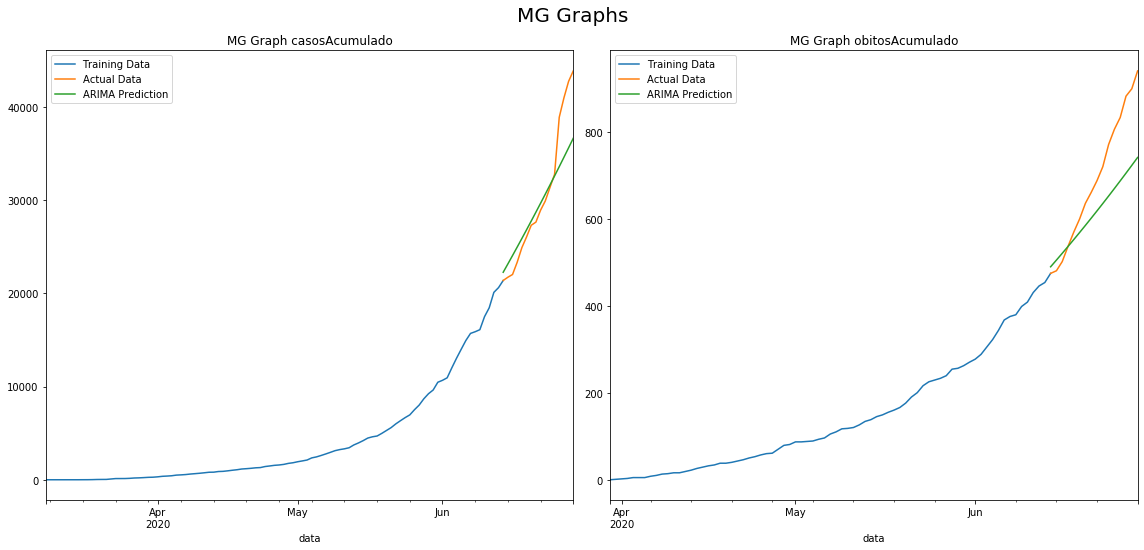

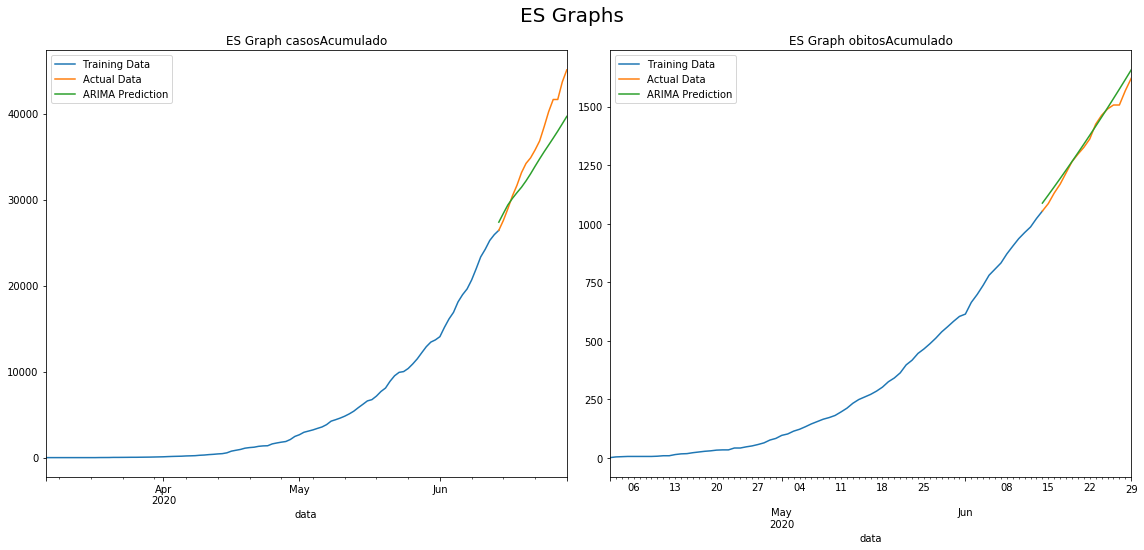

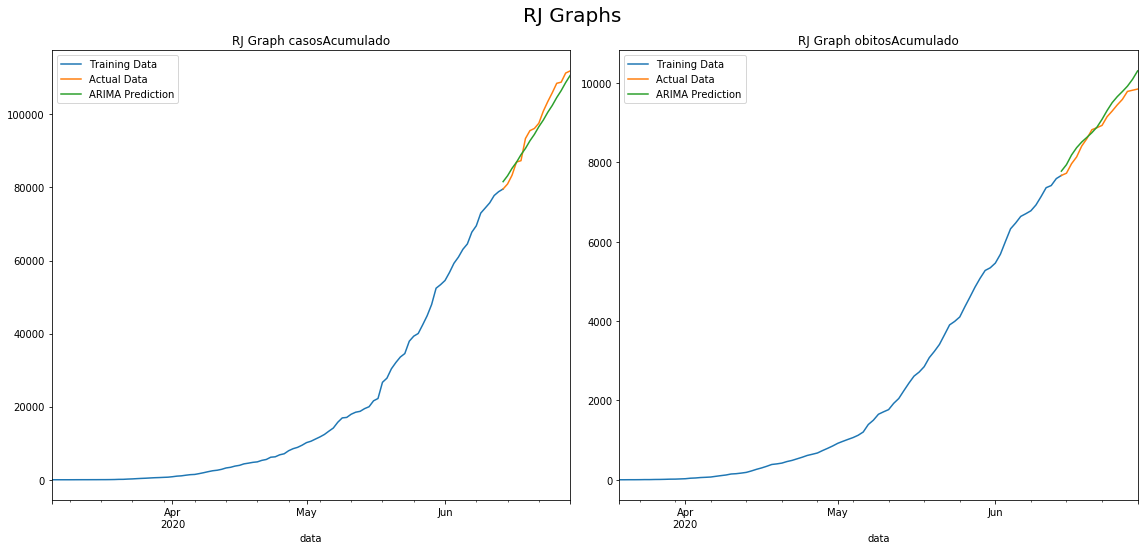

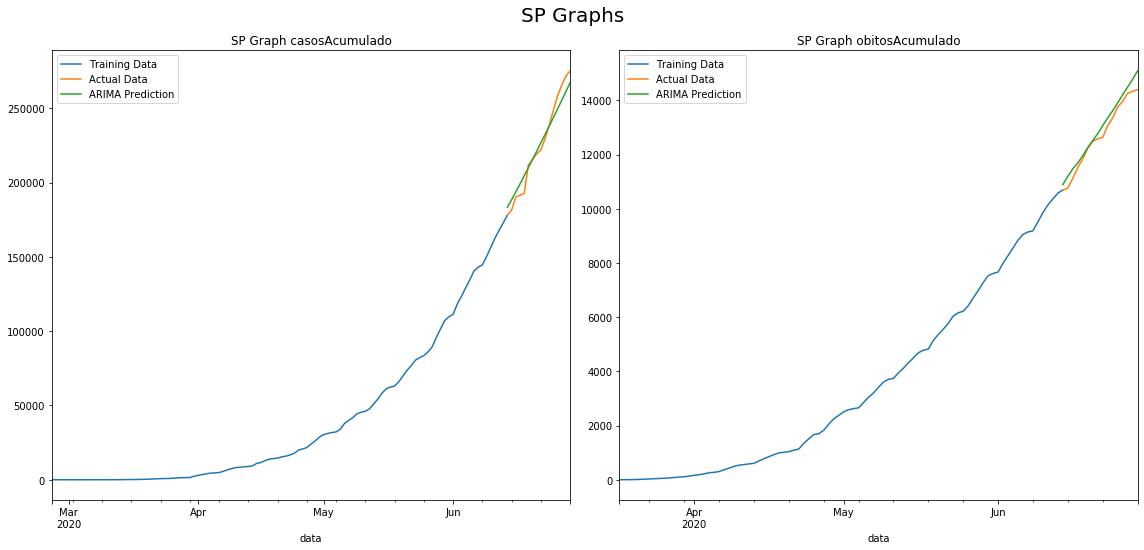

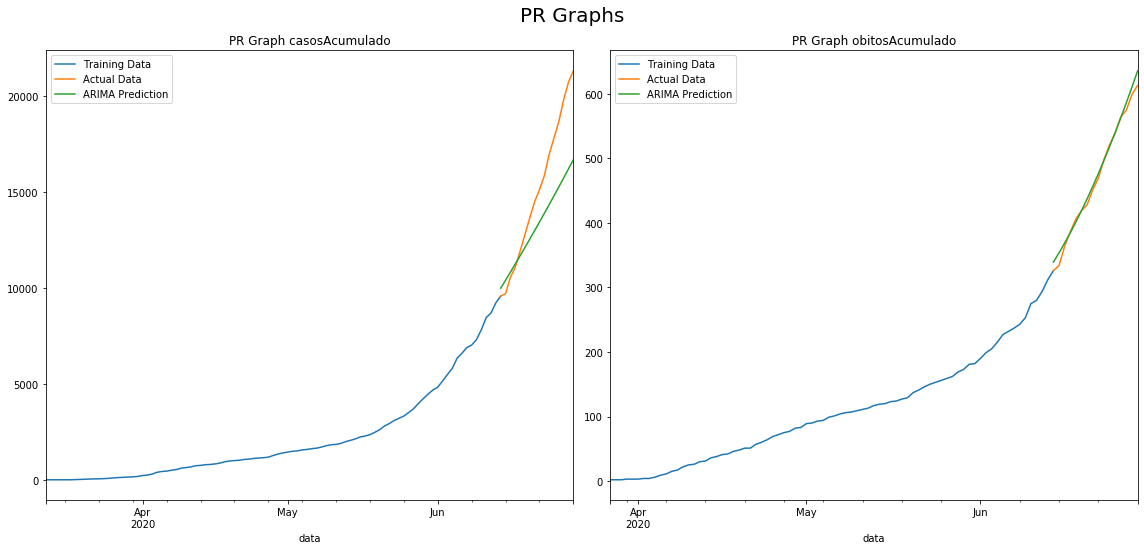

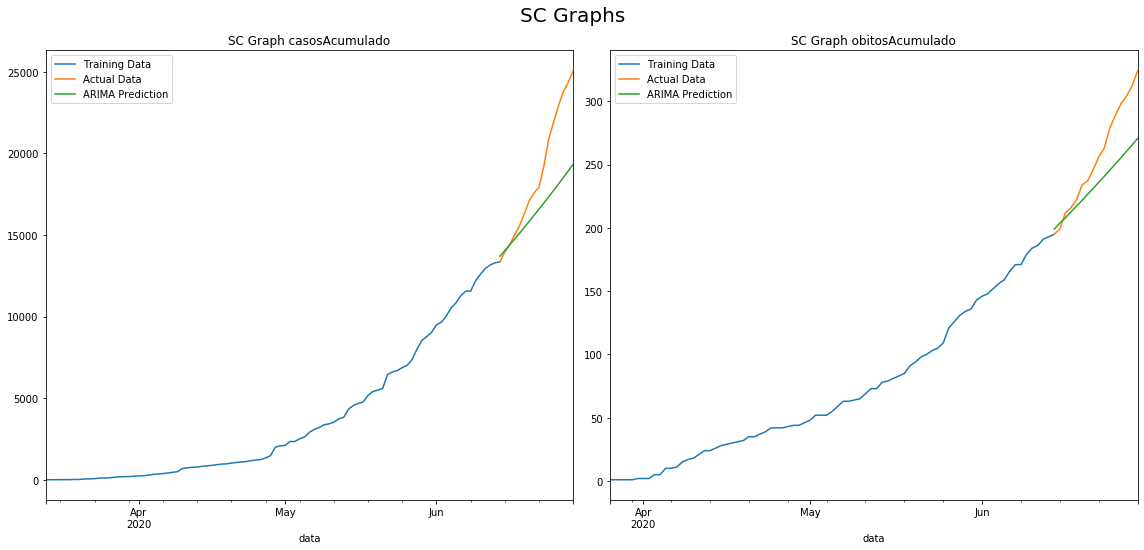

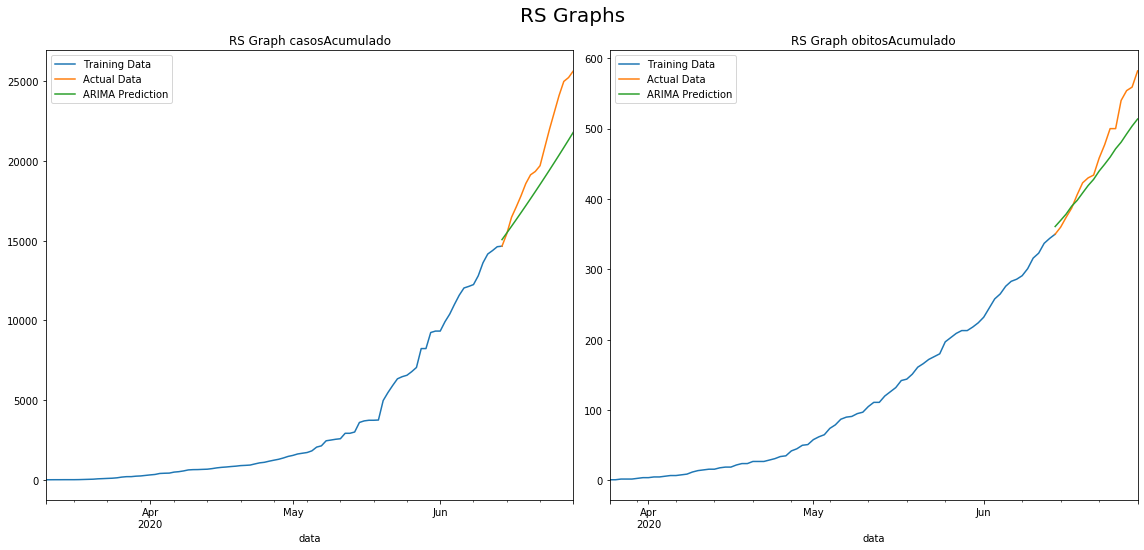

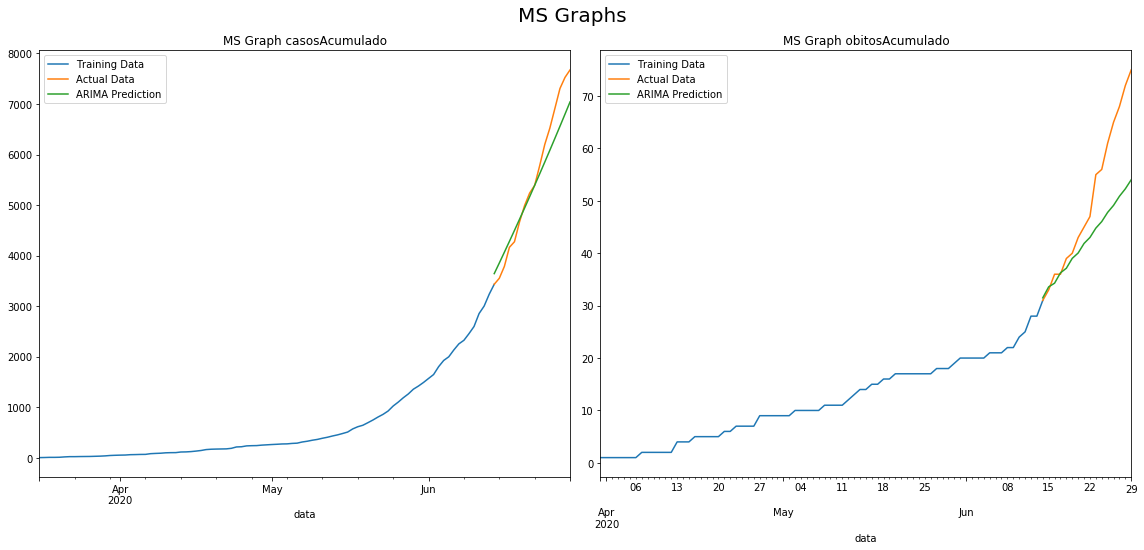

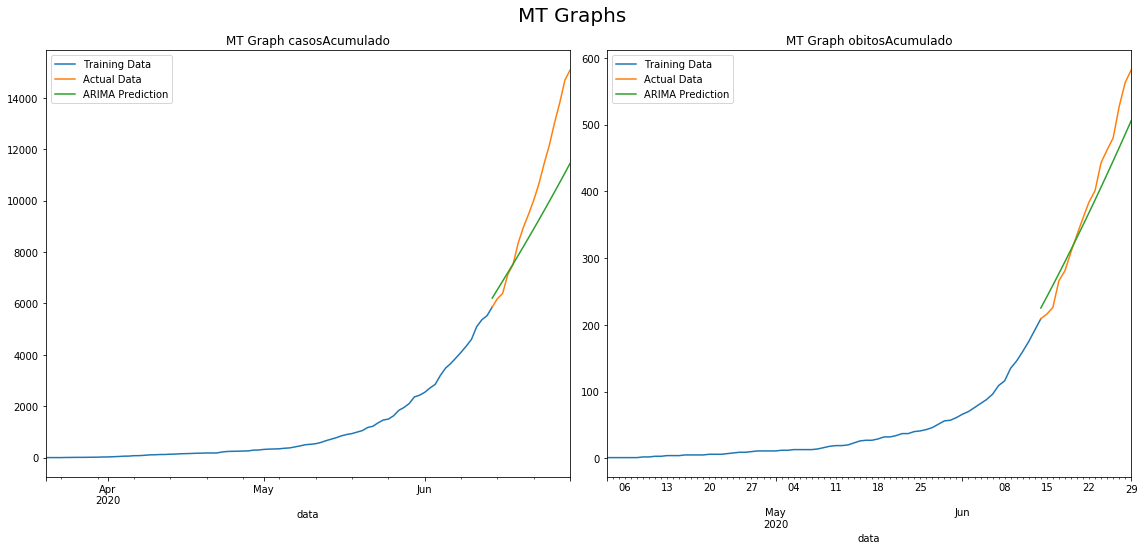

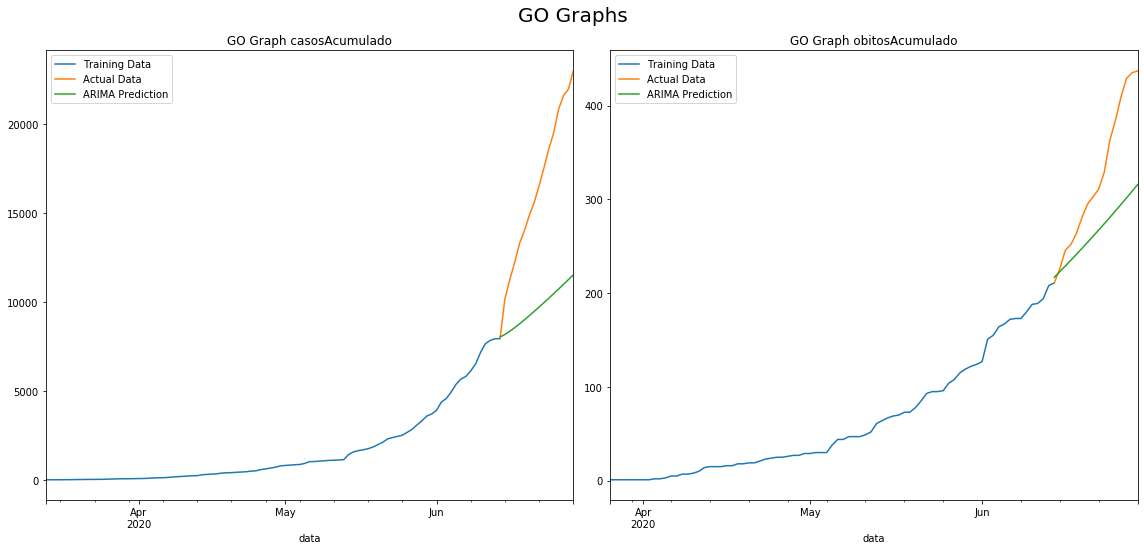

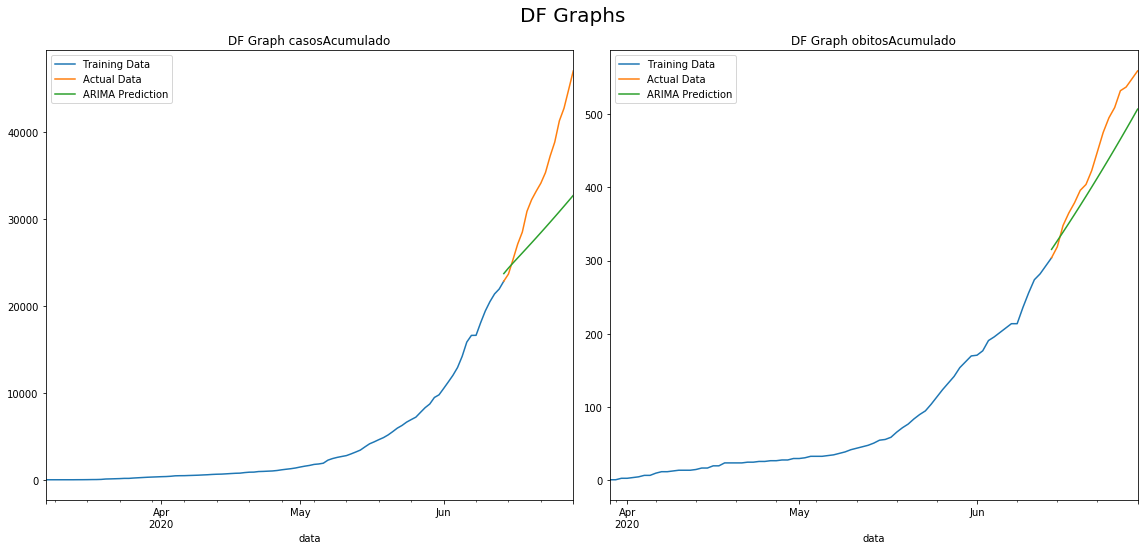

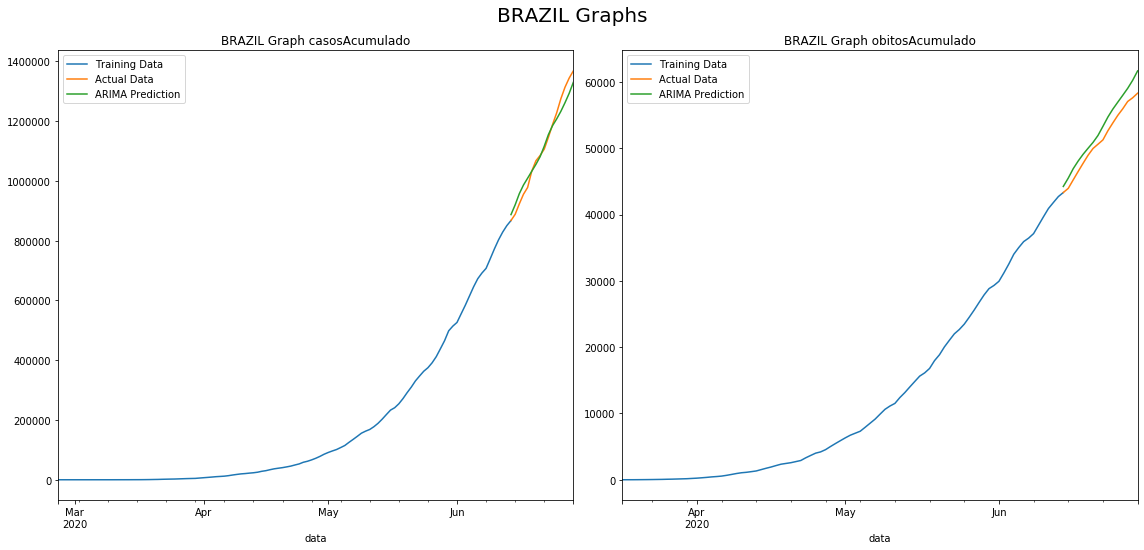

In [177]:
results_df = pd.DataFrame()

states = df["estado"].unique()
states = np.append(states, "BRAZIL") # makes sure it also takes care of Brazil as a whole

for state in states[1:]: # skips over the NAN entry for Brazil
    row = run_full_test(df, state)
    results_df = results_df.append(row, ignore_index=True)
    
results_df.to_csv("ARIMA Results\\arima_results.csv")